In [1]:
from collections import namedtuple
import pandas as pd
import numpy as np
import sympy as sp
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from hierarqcal import Qcycle, Qmask, Qinit, Qunitary, Qmotif
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
import torch
from torch import nn

In [2]:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download
# PATH_DATA = f"PATH/TO/features_30_sec.csv"
PATH_DATA = f"Data/features_30_sec.csv"
Samples = namedtuple("samples", ["x_train", "x_test", "y_train", "y_test"])
data = pd.read_csv(PATH_DATA)
# remove filename and length columns
data = data.drop(columns=["filename", "length"])
# specify genre pair
genres = ("country", "rock")
# filter data
data = data[data["label"].isin(genres)]
# set label to 0 or 1
data["label"] = data["label"].map({genres[0]: 0, genres[1]: 1})
# specify target and features
target = "label"
X, y = data.drop(columns=[target]), data[target]
# create train test split
samples_raw = Samples(*train_test_split(X, y, test_size=0.3, random_state=42))

In [3]:
# setup preprocessing pipeline
pipeline = Pipeline(
    [
        (
            "scaler",
            preprocessing.MinMaxScaler((0, np.pi / 2)),
        ),
        ("pca", PCA(8)),
    ]
)
samples_preprocessed = Samples(
    pipeline.fit_transform(samples_raw.x_train),
    pipeline.transform(samples_raw.x_test),
    samples_raw.y_train,
    samples_raw.y_test,
)

In [4]:
# set up pennylane circuit
def get_circuit(hierq, x=None):
    dev = qml.device("default.qubit.torch", wires=hierq.tail.Q)

    @qml.qnode(dev, interface="torch")
    def circuit():
        if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
            # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
            hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
        if x is not None:
            AngleEmbedding(x, wires=hierq.tail.Q, rotation="Y")
        hierq(backend="pennylane")  # This executes the compute graph in order
        return qml.probs(wires=hierq.head.Q[0])

    return circuit

In [5]:
# set up train loop
def train(x, y, motif, N=70, lr=0.1, verbose=True):
    n_symbols = motif.n_symbols
    if n_symbols > 0:
        symbols = torch.rand(n_symbols, requires_grad=True)
        opt = torch.optim.Adam([symbols], lr=lr)
        for it in range(N):
            opt.zero_grad()
            loss = objective_function(motif, symbols, x, y)
            loss.backward()
            opt.step()
            if verbose:
                if it % 10 == 0:
                    print(f"Loss at step {it}: {loss}")
    else:
        symbols = None
        loss = objective_function(motif, [], x, y)
    return symbols, loss

In [6]:
# specify objective function
def objective_function(motif, symbols, x, y):
    motif.set_symbols(symbols)
    circuit = get_circuit(motif, x)
    y_hat = circuit()
    # cross entropy loss
    m = nn.Sigmoid()
    loss = nn.BCELoss()
    # index 1 corresponds to predictions for being in class 1
    # use mse
    loss = nn.MSELoss()
    loss = loss(y_hat[:, 1], torch.tensor(y.values, dtype=torch.double))
    # loss = loss(m(y_hat[:,1]),torch.tensor(y.values,dtype=torch.double))
    return loss

In [7]:
# Create Qcnn
def penny_gate_to_function(gate):
    return lambda bits, symbols: gate(*symbols, wires=[*bits])


primitive_gates = ["CRZ", "CRX", "CRY", "RZ", "RX", "RY", "Hadamard", "CNOT", "PauliX"]
penny_gates = [getattr(qml, gate_name) for gate_name in primitive_gates]
hierq_gates = {
    primitive_gate: Qunitary(
        penny_gate_to_function(penny_gate),
        n_symbols=penny_gate.num_params,
        arity=penny_gate.num_wires,
    )
    for primitive_gate, penny_gate in zip(primitive_gates, penny_gates)
}

In [8]:
# ========================================== experiment using conv ansatz (g)
def ansatz(bits, symbols):  # 10 params
    qml.RX(symbols[0], wires=bits[0])
    qml.RX(symbols[1], wires=bits[1])
    qml.RZ(symbols[2], wires=bits[0])
    qml.RZ(symbols[3], wires=bits[1])
    qml.CRZ(symbols[4], wires=[bits[1], bits[0]])
    qml.CRZ(symbols[5], wires=[bits[0], bits[1]])
    qml.RX(symbols[6], wires=bits[0])
    qml.RX(symbols[7], wires=bits[1])
    qml.RZ(symbols[8], wires=bits[0])
    qml.RZ(symbols[9], wires=bits[1])
    
    
qcnn = (
    Qinit(8)
    + (
        Qcycle(
            stride=1,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz, n_symbols=10, arity=2),
            share_weights=True,
        )
        + Qmask("!*", mapping=hierq_gates["CNOT"])
    )
    * 3
)

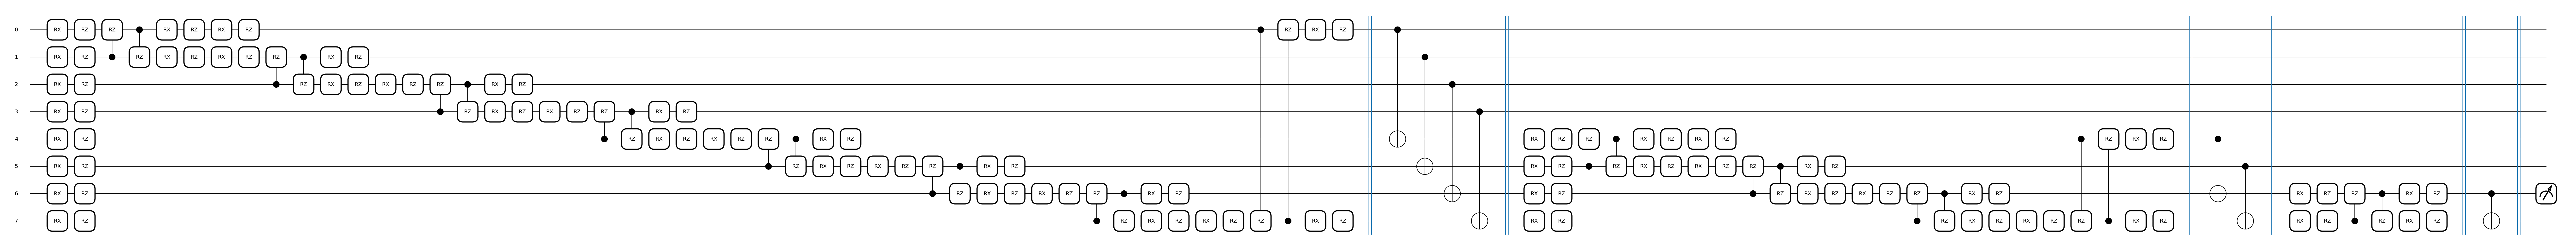

In [9]:
# plot circuit
fig, ax = qml.draw_mpl(get_circuit(qcnn))()

In [10]:
# train qcnn
symbols, loss = train(samples_preprocessed.x_train, samples_preprocessed.y_train, qcnn)
# get predictions
circuit = get_circuit(qcnn, samples_preprocessed.x_test)
y_hat = circuit()
# evaluate
y_hat = torch.argmax(y_hat, axis=1).detach().numpy()
accuracy = sum(
    [y_hat[k] == samples_preprocessed.y_test.values[k] for k in range(len(y_hat))]
) / len(y_hat)

print(accuracy)

Loss at step 0: 0.25560071473663787
Loss at step 10: 0.21800331717330773
Loss at step 20: 0.1917122352183815
Loss at step 30: 0.1856378219912318
Loss at step 40: 0.17770828927105384
Loss at step 50: 0.17276522934421082
Loss at step 60: 0.17207380819488083
0.7333333333333333


In [11]:
# ========================================== experiment using new alteration of conv ansatz (g)
def ansatz(bits, symbols):  # 10 params
    qml.RX(symbols[0], wires=bits[0])
    qml.RX(symbols[1], wires=bits[1])
    qml.RZ(symbols[2], wires=bits[0])
    qml.RZ(symbols[3], wires=bits[1])
    qml.CRZ(symbols[4], wires=[bits[1], bits[0]])
    qml.CRZ(symbols[5], wires=[bits[0], bits[1]])
    qml.RX(symbols[6], wires=bits[0])
    qml.RX(symbols[7], wires=bits[1])
    qml.RZ(symbols[8], wires=bits[0])
    qml.RZ(symbols[9], wires=bits[1])
    
    
qcnn_altered = (
    Qinit(8)
    + (
        Qcycle(
            stride=2,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz, n_symbols=10, arity=2),
            share_weights=True,
        )
        + Qmask("!*", mapping=hierq_gates["CNOT"], strides=1)
    )
    * 3
)

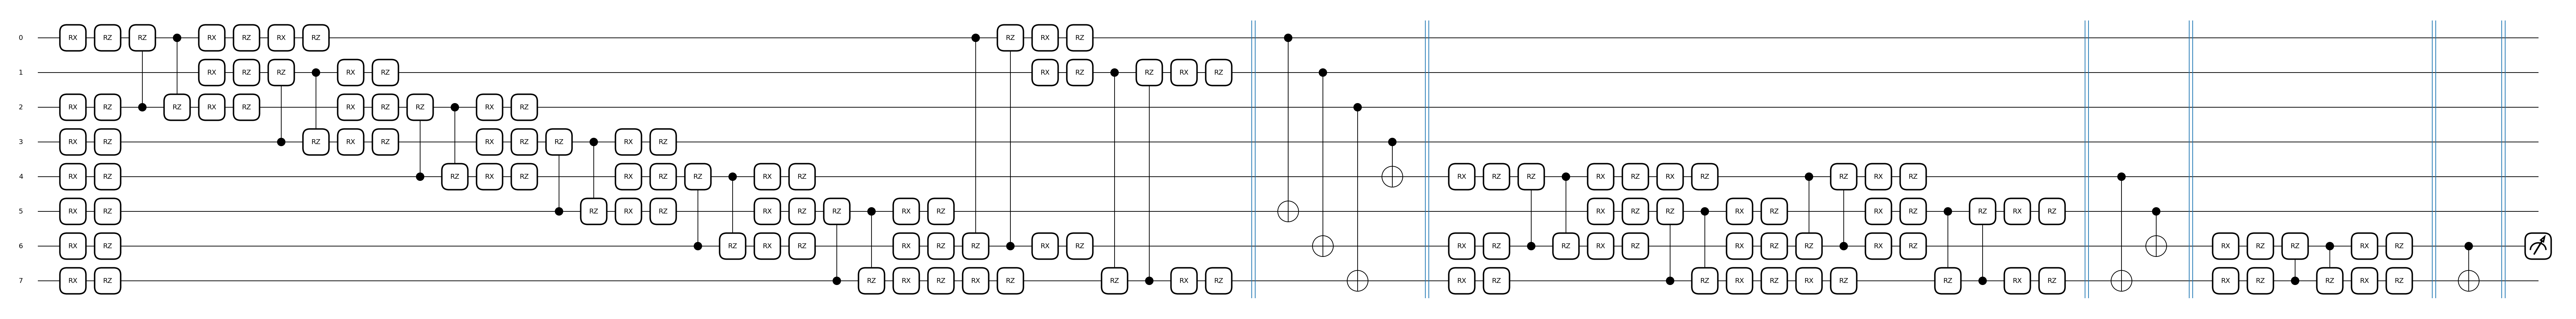

In [12]:
# plot circuit
fig, ax = qml.draw_mpl(get_circuit(qcnn_altered))()

In [13]:
# train qcnn
symbols, loss = train(samples_preprocessed.x_train, samples_preprocessed.y_train, qcnn_altered)
# get predictions
circuit = get_circuit(qcnn_altered, samples_preprocessed.x_test)
y_hat = circuit()
# evaluate
y_hat = torch.argmax(y_hat, axis=1).detach().numpy()
accuracy = sum(
    [y_hat[k] == samples_preprocessed.y_test.values[k] for k in range(len(y_hat))]
) / len(y_hat)

print(accuracy)

Loss at step 0: 0.2946149066936859
Loss at step 10: 0.20610740871214506
Loss at step 20: 0.19453625873048008
Loss at step 30: 0.189673850589941
Loss at step 40: 0.1862901233603989
Loss at step 50: 0.18556781454929444
Loss at step 60: 0.18492412458080382
0.7833333333333333
